### Model recovery


In [29]:
import pyabc
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from pyabc.transition import Transition, MultivariateNormalTransition
from pyabc.weighted_statistics import weighted_quantile
from sklearn.metrics import confusion_matrix
models = ['basic',  'gradedmugo', 'scaledguessing', 'fullabcd', 'cacaphony']

def get_db(generator):
    assert generator in models
    modelstring = '_'.join(models)
    history = pyabc.History(f'sqlite:///results/generative_{generator}_{modelstring}_adaptive_distance.db')
    assert history.id is not None
    print(history.id)
    print(history.model_names())
    return(history)

def plot_model_probabilities(db, generator):
    basic_prob = db.get_model_probabilities()
    plt.figure(figsize=(6,4))
    plt.plot(basic_prob)
    plt.xlabel('populations')
    plt.ylabel('Model probability')
    plt.legend(models)
    plt.title(f'Generating model: {generator}')

def get_model_parameters():
    parameters = {}
    for model in models:
        with open(f'params/params_{model}.json') as f:
            parameters[model] = json.load(f)
    return(parameters)

In [15]:
parameters = get_model_parameters()


In [21]:
# for each model, get # of databases

model_prob_dict = defaultdict(lambda: {})
for model in models:
    dbstring = f'sqlite:///results/generative_{model}_{modelstring}_adaptive_distance.db'
    modelstring = '_'.join(models)
    history = pyabc.History(dbstring)
    assert history.id is not None
    print(model, history.id)
    model_prob_dict[model] = {}
    for run in range(1, history.id + 1):
        history_run = pyabc.History(dbstring, _id=run)
        if history_run.id is not None:
            if history_run.max_t < 3:
                continue
            model_prob_dict[model][run] = history_run.get_model_probabilities()
        else:
            print(model, run, None)

basic 15
gradedmugo 14
scaledguessing 15
fullabcd 15
cacaphony 15


In [37]:
model_selections = []

for model, probs in model_prob_dict.items():
    for run, model_prob in probs.items():
        final_probs = model_prob.iloc[-1, :]
        model_selections.append([models.index(model), np.argmax(final_probs)])

model_selections = np.array(model_selections)
confusion_df = pd.DataFrame(confusion_matrix(model_selections[:, 0], 
                                             model_selections[:, 1],
                                             normalize='true'),
    index=pd.Index(data=models, name='True'),
    columns=pd.Index(data=models, name='Selected'))

confusion_df

Selected,basic,gradedmugo,scaledguessing,fullabcd,cacaphony
True,,,,,
basic,0.928571,0.000000,0.071429,0.000000,0.000000
gradedmugo,0.000000,0.142857,0.000000,0.785714,0.071429
scaledguessing,0.000000,0.000000,0.800000,0.000000,0.200000
fullabcd,0.000000,0.000000,0.000000,0.266667,0.733333
cacaphony,0.000000,0.000000,0.000000,0.066667,0.933333


## Compare estimated parameters to generating parameters

In [83]:


def get_model_parameters(history, modelnum):
    # extracted from pyabc plotting function
    df, w = history.get_distribution(m=modelnum, t=history.max_t)
    par_names = list(df.columns.values)
    n_par = len(par_names)

    # adapted from pyabc.plot_credible_intervals
    median = {}

    # normalize weights to be sure
    w /= w.sum()
    # iterate over parameters
    for i_par, par in enumerate(par_names):
        # as numpy array
        vals = np.array(df[par])
        # median
        median[par] = weighted_quantile(vals, w, alpha=0.5)

    return(median)

def get_true_parameters(params):
    # get matching parameters for model
    return({
        'mu_go': params['mu']['go'],
        'mu_stop_delta': params['mu']['stop'] - params['mu']['go'],
        'mu_delta_incorrect': params['mu_delta_incorrect'],
        'nondecision': params['nondecision']['go'],
        'noise_sd': params['noise_sd']['go']})

model, modelnum = 'basic', 0
df = {}
trueparams = get_true_parameters(parameters[model])

estparams = {}

dbstring = f'sqlite:///results/generative_{model}_{modelstring}_adaptive_distance.db'
modelstring = '_'.join(models)
history = pyabc.History(dbstring)
assert history.id is not None
print(model, history.id)

for run in range(1, history.id + 1):
    history_run = pyabc.History(dbstring, _id=run)
    if history_run.id is not None:
        if history_run.max_t < 3:
            continue
    estparams[run] = get_model_parameters(history_run, modelnum)

estparams_df = pd.DataFrame(estparams)

basic 15


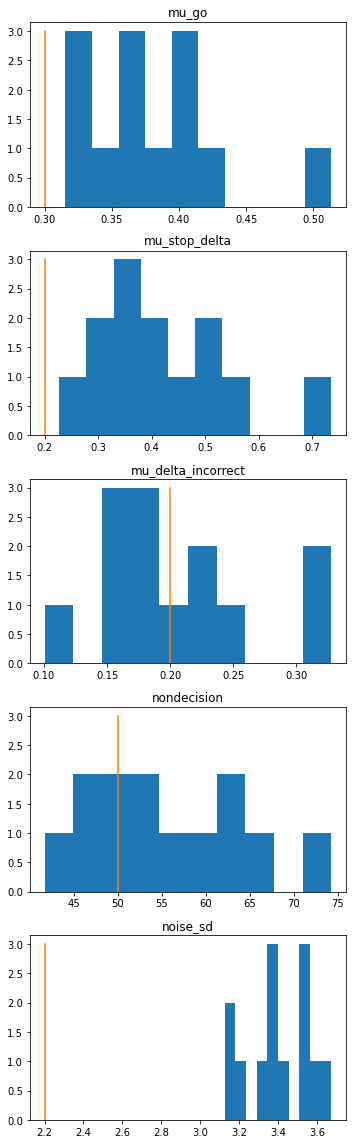

In [97]:
varnames = list(trueparams.keys())
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5, 16), tight_layout=True)
for i, v in enumerate(varnames):
    ax[i].hist(estparams_df.loc[v, :])
    ax[i].plot([trueparams[v], trueparams[v]], [0, 3])
    ax[i].set_title(v)


In [76]:

df = pd.DataFrame({'mean_est': estparams_df.mean(axis=1), 'true': 0})
for p, value in trueparams.items():
    df.loc[p, 'true'] = value

df

,mean_est,true
mu_delta_incorrect,0.204045,0.2
mu_go,0.378219,0.3
mu_stop_delta,0.420473,0.2
noise_sd,3.406607,2.2
nondecision,55.463027,50.0


In [114]:
## Compare true results to estimated results

from stopsignalmodel import StopSignalModel


ssm = StopSignalModel(model, parameters=parameters[model])
sim_results = ssm.fit_transform(estparams_df.mean(axis=1).to_dict())

observed_data = ssm.fit_transform(trueparams)
results_df = pd.DataFrame(columns=['fitted_params', 'true_params'])

for k in sim_results:
    if not k.find('presp')>-1 and not k.find('accuracy')>-1:
        # print(k, simulation[k], observed_data[k])
        results_df.loc[k] = [sim_results[k], observed_data[k]]

ssdvals = np.arange(0, 501, 50)

ssd_df = pd.DataFrame(
    columns=['SSD', 'presp_true', 'presp_fitted', 'accuracy_true', 'accuracy_fitted'])
for i, ssd in enumerate(ssdvals):
    ssd_df.loc[i, :] = [
        ssd,
        observed_data[f'presp_{i}'],
        sim_results[f'presp_{i}'],
        observed_data[f'accuracy_{i}'],
        sim_results[f'accuracy_{i}'],
    ]

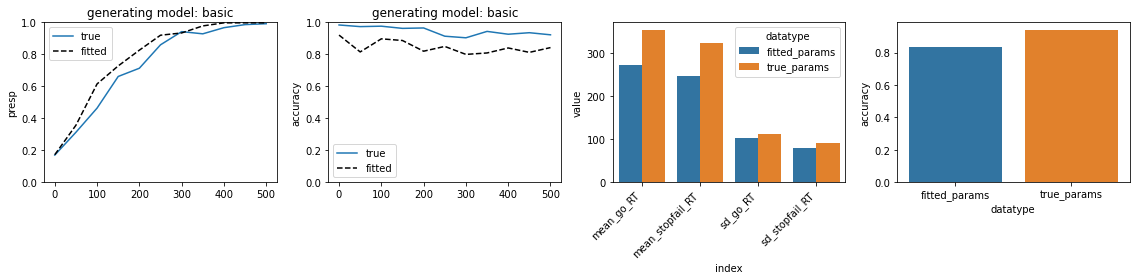

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
foo = pd.melt(results_df.reset_index(), 'index', var_name='datatype')
RT_vars = foo[foo['index'].str.contains('RT')]
#
acc_vars = foo[foo['index'].str.contains('acc')].rename(columns={'value':'accuracy'})
#

for i, datatype in enumerate(['presp', 'accuracy']):
    ax[i].plot(ssd_df.SSD, ssd_df[f'{datatype}_true'])
    ax[i].plot(ssd_df.SSD, ssd_df[f'{datatype}_fitted'], 'k--')
    ax[i].set_title(f'generating model: {model}')
    ax[i].legend(['true', 'fitted'])
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel(datatype)

rtplot = sns.barplot(x='index', y='value', hue='datatype', data=RT_vars, ax=ax[2])
rtplot.set_xticklabels(rtplot.get_xticklabels(), 
                        rotation=45, 
                        horizontalalignment='right')
plt.tight_layout()
sns.barplot(x='datatype', y='accuracy', data=acc_vars, ax=ax[3])

plt.savefig('simulation_vs_true.pdf')